# Annotation

## Settings 

In [1]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed'
test = 'all'

# Gene annotation
GTF_PATH = "/mnt/flatfiles/organisms/new_organism/mus_musculus/104/mus_musculus.104.genes.gtf"
ENSEMBL_DATASET = "mmusculus_gene_ensembl" # This is used for replaceing ensembl gene IDs with gene names if possible
                                           # use "hsapiens_gene_ensembl" for homo sapiens
# Cell type annotation
SPECIES = "Mm" # Currently only Hs (Homo Sapiens) and Mm (Mus Musculus) are available for custom cell type annotation
SCSA_SPECIES = None # Currently only human (Homo Sapiens) and mouse (Mus Musculus) are available for SCSA
                    # None if using a custom DB file
SCSA_CUSTOM_DB_PATH = "/mnt/workspace/mkessle/projects/marker_repo/dbs/mouse_new" # Optional custom database for SCSA
PANGLAO_DB_PATH = "/mnt/workspace/jdetlef/sc-atac-framework/ctannot/panglao_markers"
RESOLUTIONS = "leiden_0.4" # Choose "None" to keep the selection of the clustering resolution from the previous notebook
                           # You can also choose a column which contains the clustering information in the obs table
                           # It is also possible to add more than one column (resolutions) by using a list of columns

## Loading packages and setup

In [2]:
import sctoolbox.atac_tree as sub_tree
import sctoolbox.annotation as annot
import sctoolbox.custom_celltype_annotation as ctannot
from sctoolbox.celltype_annotation import run_scsa
import pandas as pd
import episcanpy as epi
import scanpy as sc
from matplotlib import pyplot as plt
from pybiomart import Dataset

## Setup path handling object 

In [3]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


In [4]:
tree.gtf_path = GTF_PATH

## Load anndata

In [5]:
clustering_output = tree.clustering_anndata
adata = epi.read_h5ad(clustering_output)
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,highly_variable
chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,374,176,0.003270,0.003265,99.672978,176.0,5.176150,176,274.0,True
chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,477,3938,0.073171,0.070618,92.682882,3938.0,8.278682,3938,7932.0,False
chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,285,966,0.017949,0.017790,98.205095,966.0,6.874198,966,1788.0,True
chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,256,126,0.002341,0.002338,99.765882,126.0,4.844187,126,289.0,True
chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,233,491,0.009123,0.009082,99.087683,491.0,6.198479,491,1040.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,266,1040,0.019324,0.019140,98.067597,1040.0,6.947937,1040,2128.0,True
chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,247,286,0.005314,0.005300,99.468589,286.0,5.659482,286,521.0,True
chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,402,272,0.005054,0.005041,99.494602,272.0,5.609472,272,507.0,True
chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,221,156,0.002899,0.002894,99.710140,156.0,5.056246,156,229.0,True


In [6]:
if RESOLUTIONS:
    if type(RESOLUTIONS) == str:
        RESOLUTIONS = [RESOLUTIONS]
else:
    RESOLUTIONS = adata.uns['infoprocess']['leiden_res']

In [7]:
# FIX FOR THE EXT442
#adata.var['peak_chr'] = adata.var['peak_chr'].astype(str)
#adata.var['peak_start'] = adata.var['peak_start'].astype(int)
#adata.var['peak_end'] = adata.var['peak_end'].astype(int)

In [8]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,highly_variable
chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,374,176,0.003270,0.003265,99.672978,176.0,5.176150,176,274.0,True
chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,477,3938,0.073171,0.070618,92.682882,3938.0,8.278682,3938,7932.0,False
chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,285,966,0.017949,0.017790,98.205095,966.0,6.874198,966,1788.0,True
chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,256,126,0.002341,0.002338,99.765882,126.0,4.844187,126,289.0,True
chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,233,491,0.009123,0.009082,99.087683,491.0,6.198479,491,1040.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,266,1040,0.019324,0.019140,98.067597,1040.0,6.947937,1040,2128.0,True
chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,247,286,0.005314,0.005300,99.468589,286.0,5.659482,286,521.0,True
chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,402,272,0.005054,0.005041,99.494602,272.0,5.609472,272,507.0,True
chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,221,156,0.002899,0.002894,99.710140,156.0,5.056246,156,229.0,True


## Gene annotation 

In [9]:
annot.annotate_adata(adata,
                   GTF_PATH,
                   config=None,
                   best=True,
                   threads=6,
                   coordinate_cols=None,
                   temp_dir="",
                   verbose=True,
                   inplace=True)

Setting up annotation configuration...
Config dictionary: {'queries': [{'distance': [10000, 1000], 'feature_anchor': ['start'], 'feature': ['gene'], 'name': 'promoters'}], 'priority': True, 'show_attributes': ['all'], 'output_by_query': False}
Setting up genomic regions to annotate...
Index(['peak_chr', 'peak_start', 'peak_end'], dtype='object')
Preparing gtf file for annotation...
- Reading gtf with Tabix
- Index of gtf not found - trying to index gtf
- Reading gtf with Tabix
Done preparing gtf!
Annotating regions...
Formatting annotations...
These columns will be overwritten by the annotation
Finished annotation of features! The results are found in the .var table.
[Errno 2] No such file or directory: ''


In [10]:
adata.var['gene_name']

chr1:3050427-3050801            NaN
chr4:129518038-129518515    Ccdc28b
chr4:129518849-129519134    Ccdc28b
chr4:129527627-129527883        NaN
chr4:129533947-129534180      Txlna
                             ...   
chr4:129517580-129517846    Ccdc28b
chr1:192477325-192477572        NaN
chr1:37026210-37026612          NaN
chr1:7849890-7850111            NaN
chr1:3191548-3191937            NaN
Name: gene_name, Length: 145907, dtype: category
Categories (25284, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s162', 'n-R5s41']

In [11]:
assigned_features = adata.var['gene_name'].dropna()
assigned_features

chr4:129518038-129518515    Ccdc28b
chr4:129518849-129519134    Ccdc28b
chr4:129533947-129534180      Txlna
chr4:129534299-129535110      Txlna
chr4:129539961-129540183      Txlna
                             ...   
chr4:129502294-129503161      Eif3i
chr4:129503825-129504508      Eif3i
chr4:129512576-129513315       Iqcc
chr4:129515107-129515508       Iqcc
chr4:129517580-129517846    Ccdc28b
Name: gene_name, Length: 44074, dtype: category
Categories (25284, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s162', 'n-R5s41']

### Replace ensembl gene IDs with gene names if possible

In [12]:
dataset = Dataset(name=ENSEMBL_DATASET,
                  host='http://www.ensembl.org')

df = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])

In [13]:
ens_dict = dict(zip(df['Gene stable ID'], df['Gene name']))

In [14]:
count = 0
for index, gene in enumerate(assigned_features):
    if gene.startswith("ENSG"):
        if gene in ens_dict.keys():
            if isinstance(ens_dict[gene], str):
                assigned_features.replace(gene, ens_dict[gene], inplace=True)
                count += 1
print(f'{count} ensembl gene ids have been replaced with gene names')

0 ensembl gene ids have been replaced with gene names


In [15]:
assigned_features

chr4:129518038-129518515    Ccdc28b
chr4:129518849-129519134    Ccdc28b
chr4:129533947-129534180      Txlna
chr4:129534299-129535110      Txlna
chr4:129539961-129540183      Txlna
                             ...   
chr4:129502294-129503161      Eif3i
chr4:129503825-129504508      Eif3i
chr4:129512576-129513315       Iqcc
chr4:129515107-129515508       Iqcc
chr4:129517580-129517846    Ccdc28b
Name: gene_name, Length: 44074, dtype: category
Categories (25284, object): ['0610006L08Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik', ..., 'mmu-mir-7676-1', 'mmu-mir-7679', 'n-R5s162', 'n-R5s41']

In [16]:
assigned_adata = adata[:, assigned_features.index]
assigned_adata

View of AnnData object with n_obs × n_vars = 53819 × 44074
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_fragments_in_promoters', 'n_total_fragments', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features', 'leiden', 'LISI_score_X_pca', 'LISI_score_X_umap', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'clustering'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand

## Rank peaks

In [17]:
peaks_adata = assigned_adata.copy()

In [18]:
peaks_adata.uns['log1p']['base'] = None

In [19]:
for column in RESOLUTIONS:
    print(f'Ranking peaks for clusters using obs column {column}')
    epi.tl.rank_features(peaks_adata, f'{column}', omic='ATAC', 
                         key_added=f'rank_features_groups_{column}', n_features=100, use_raw=False)
    
print('Done')

Ranking peaks for clusters using obs column leiden_0.4
Done


## Rank genes
Replace peaks with gene names

In [20]:
genes_adata = peaks_adata.copy()
genes_adata.var.reset_index(inplace=True)  # remove peaks from index and save them in the column ['index']
genes_adata.var.set_index('gene_name',inplace=True)  # set genes as index
genes_adata.var.index = genes_adata.var.index.astype('str')  # to avoid index being categorical
genes_adata.var_names_make_unique(join='_')
genes_adata.raw = genes_adata

In [21]:
for column in RESOLUTIONS:
    print(f'Ranking genes groups for clusters using obs column {column}')
    sc.tl.rank_genes_groups(genes_adata, groupby=f'{column}', use_raw=False, key_added=f'rank_genes_groups_{column}')

print('Done')

Ranking genes groups for clusters using obs column leiden_0.4
Done


### Plot ranked genes

Plotting ranked genes groups for clustering column leiden_0.4


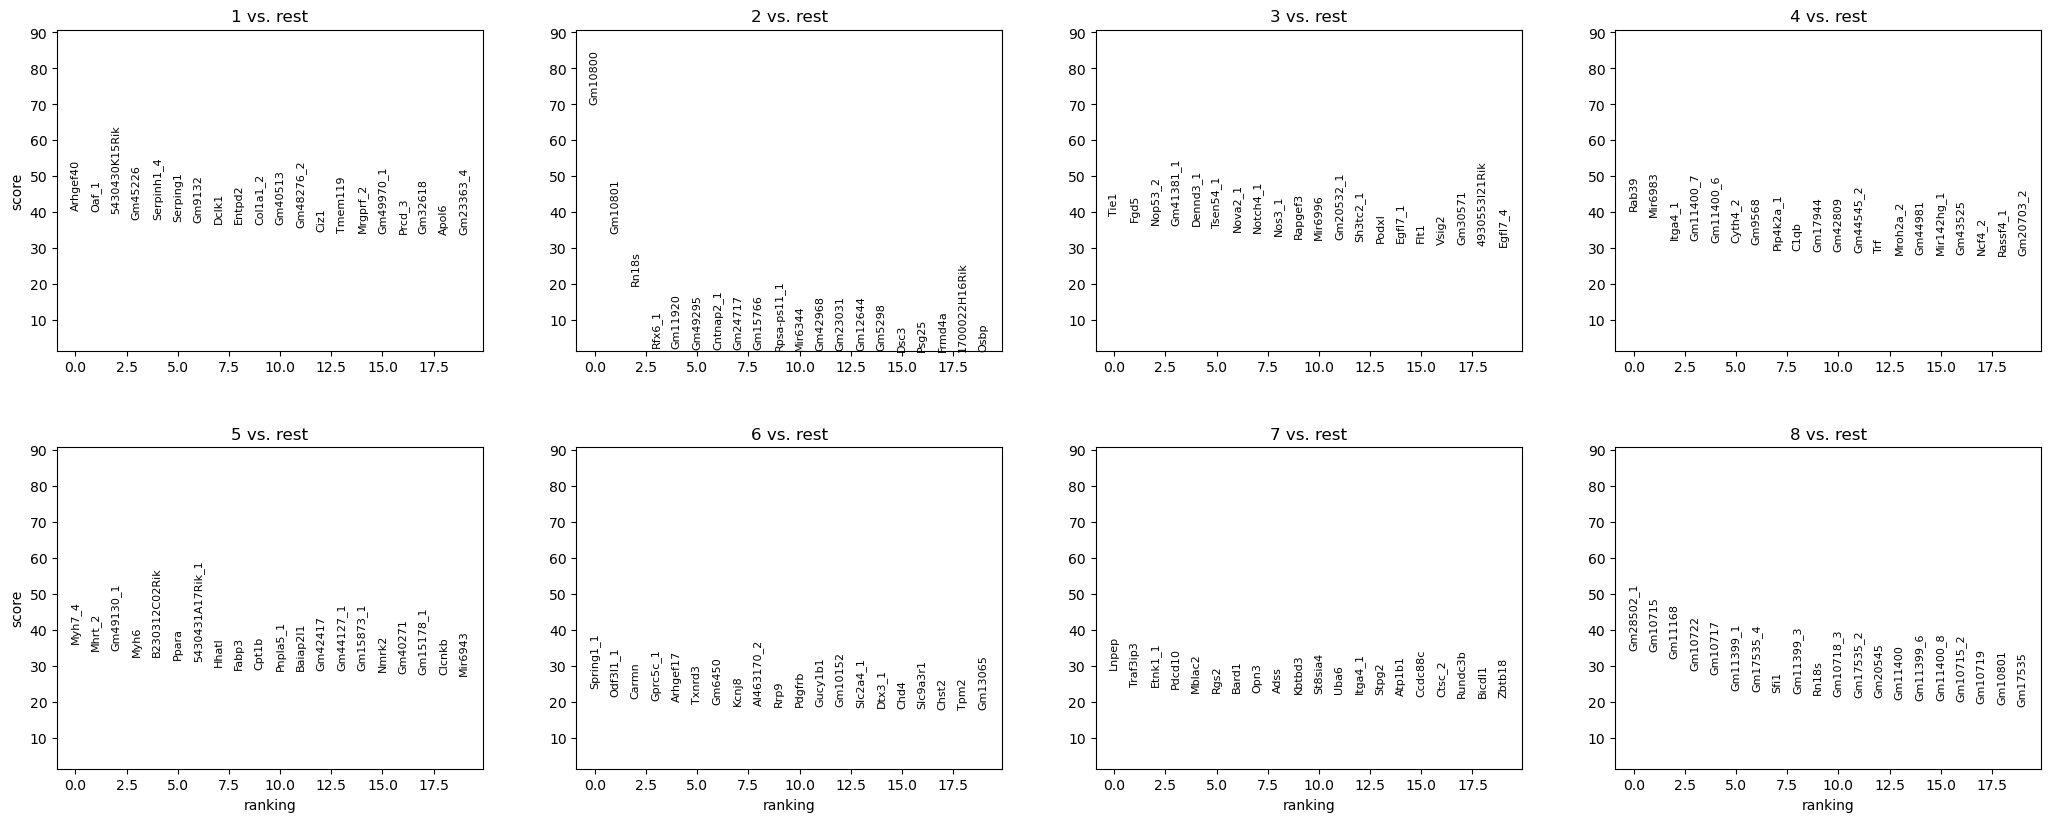

In [22]:
for column in RESOLUTIONS:
    print(f'Plotting ranked genes groups for clustering column {column}')
    plot_key = 'rank_genes_groups_' + str(column)
    sc.pl.rank_genes_groups(genes_adata, key=plot_key, show=False)
    # TODO
    # if save_figs:
    #    plt.savefig(f'{OUTPUT_FIGS}/ranked_genes_groups_leiden_{res}.png')
    plt.show()

Plotting matrixplot for clustering column leiden_0.4


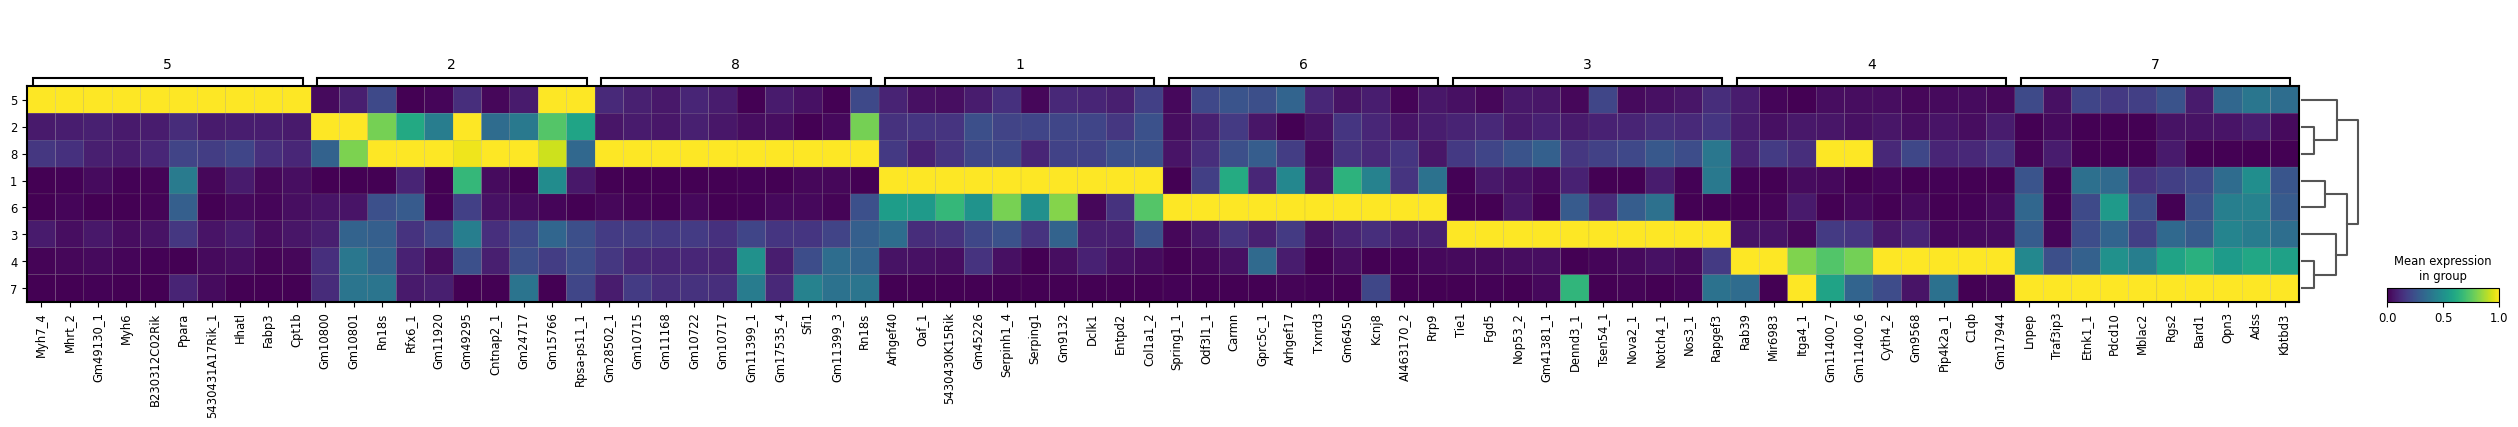

In [23]:
for column in RESOLUTIONS:
    print(f'Plotting matrixplot for clustering column {column}')
    plot_key = 'rank_genes_groups_' + str(column)
    sc.pl.rank_genes_groups_matrixplot(genes_adata, standard_scale='var', n_genes=10, key=plot_key, show=False)
    # TODO
    # if save_figs:
    #    plt.savefig(f'{OUTPUT_FIGS}/ranked_genes_groups_matrixplot_leiden_{res}.png')
    plt.show()

## Cell type annotation

In [24]:
for column in RESOLUTIONS:
    ctannot.annot_ct(adata=adata, genes_adata=genes_adata, output_path=tree.annotation_dir, 
                     db_path=f"{PANGLAO_DB_PATH}", cluster_path=None, cluster_column=f"{column}", 
                     rank_genes_column=f"rank_genes_groups_{column}", sample=tree.run, 
                     ct_column=f"cell_types_{column}", tissue="all", db="panglao", inplace=True, species=SPECIES)

Output folder: /mnt/workspace/jdetlef/ext_ana/processed/all/annotation/leiden_0.4/ 
DB file: /mnt/workspace/jdetlef/sc-atac-framework/ctannot/panglao_markers 
Cluster folder: /mnt/workspace/jdetlef/ext_ana/processed/all/annotation/ranked/clusters/leiden_0.4/ 
Tissue: all 
DB: panglao
Writing one file per cluster containing gene names and ranked gene scores.
Starting cell type annotation.
Adding information to the adata object.
Finished cell type annotation! The results are found in the .obs table cell_types_leiden_0.4.


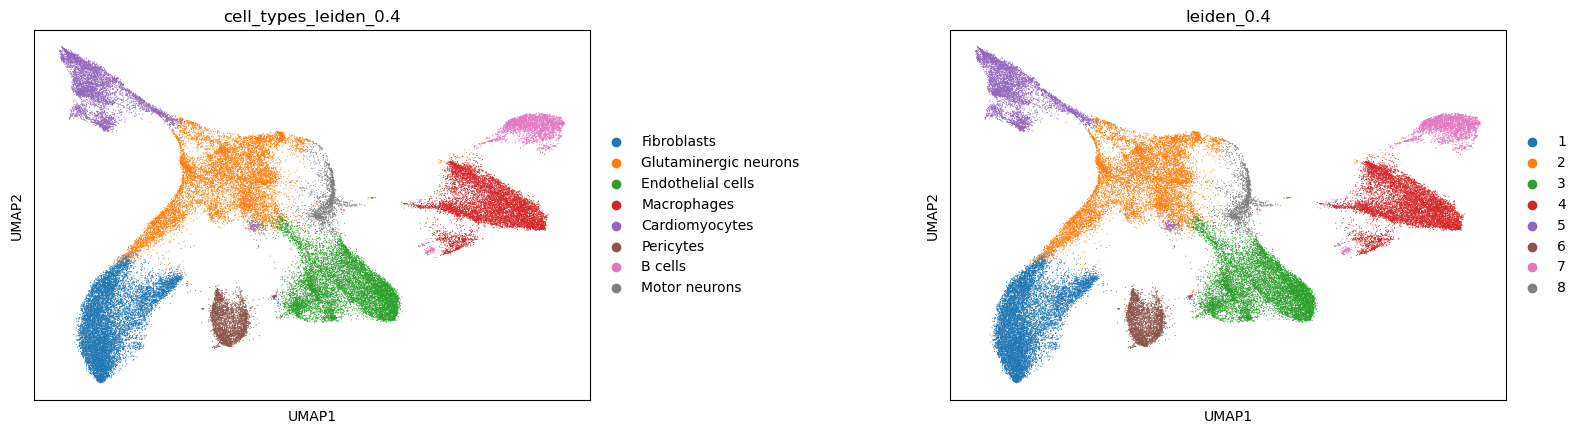

In [25]:
for column in RESOLUTIONS:
    sc.pl.umap(adata, color=[f'cell_types_{column}', f'{column}'], wspace=0.5)

In [26]:
ctannot.show_tables(annotation_dir=tree.annotation_dir, resolution=0.2, clustering_column="leiden")

,Cluster 2: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Macrophages,1404,132,495,8
1,Red pulp macrophages,1184,11,49,12
2,Langerhans cells,940,11,71,14
3,Microglia,860,71,259,7
4,Kupffer cells,833,35,127,13
5,Neutrophils,826,56,235,10
6,Osteoclast precursor cells,824,8,37,18
7,B cells,818,86,322,10
8,Monocytes,770,82,343,8
9,Eosinophils,752,18,96,17


,Cluster 3: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Endothelial cells,1622,175,600,9.0
1,Endothelial cells (aorta),879,86,280,11.0
2,Clara cells,339,14,85,17.0
3,Hematopoietic stem cells,295,75,290,8.0
4,Erythroblasts,244,21,94,7.0
5,Pinealocytes,178,15,80,19.0
6,Enterochromaffin cells,144,7,51,20.0
7,Granulosa cells,138,12,64,9.0
8,Retinal progenitor cells,130,13,37,10.0
9,Cholangiocytes,92,34,171,11.0


,Cluster 4: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Myofibroblasts,-96,9,32,6
1,Osteocytes,-112,5,18,13
2,Glutaminergic neurons,-122,9,28,10
3,Cholinergic neurons,-138,6,20,14
4,Foveolar cells,-153,10,71,12
5,Spermatozoa,-153,7,27,12
6,Nuocytes,-170,12,47,9
7,Ionocytes,-176,9,38,22
8,Parathyroid chief cells,-177,7,26,15
9,Epiblast cells,-200,15,84,9


,Cluster 7: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,B cells,892,86,322,10
1,T memory cells,623,54,198,6
2,B cells naive,560,44,170,11
3,B cells memory,505,45,172,12
4,T cells,479,78,299,8
5,T cytotoxic cells,398,6,20,9
6,Plasmacytoid dendritic cells,375,45,207,12
7,NK cells,317,61,270,12
8,Natural killer T cells,317,23,109,12
9,Thymocytes,287,18,55,11


,Cluster 1: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Fibroblasts,1302.0,167.0,553.0,8.0
1,Pancreatic stellate cells,658.0,27.0,67.0,5.0
2,Trophoblast cells,618.0,25.0,78.0,17.0
3,Peritubular myoid cells,591.0,23.0,63.0,10.0
4,Podocytes,489.0,91.0,338.0,10.0
5,Pericytes,445.0,62.0,203.0,9.0
6,Kidney progenitor cells,434.0,7.0,15.0,18.0
7,Purkinje neurons,401.0,53.0,165.0,9.0
8,Hepatic stellate cells,389.0,40.0,149.0,8.0
9,Vascular smooth muscle cells,373.0,6.0,19.0,10.0


,Cluster 6: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Pericytes,535.0,62.0,203.0,9.0
1,Vascular smooth muscle cells,295.0,6.0,19.0,10.0
2,Hepatic stellate cells,280.0,40.0,149.0,8.0
3,Mesangial cells,194.0,54.0,205.0,7.0
4,Enterochromaffin cells,155.0,7.0,51.0,20.0
5,Pancreatic stellate cells,139.0,27.0,67.0,5.0
6,Retinal progenitor cells,98.0,13.0,37.0,10.0
7,Hepatoblasts,56.0,14.0,71.0,9.0
8,Granulosa cells,44.0,12.0,64.0,9.0
9,Peritubular myoid cells,43.0,23.0,63.0,10.0


,Cluster 5: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Cardiomyocytes,3594,96,314,15
1,Myocytes,1803,80,269,16
2,Smooth muscle cells,726,73,255,10
3,Taste receptor cells,578,16,53,21
4,Distal tubule cells,571,33,129,16
5,Glomus cells,560,28,99,11
6,Interneurons,529,195,657,10
7,Motor neurons,523,13,39,22
8,Transient cells,513,21,64,13
9,Intercalated cells,513,20,75,20


,Cluster 8: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Endothelial cells,437,175,600,9
1,Endothelial cells (aorta),376,86,280,11
2,Trophoblast cells,271,25,78,17
3,Adrenergic neurons,270,6,19,17
4,Kidney progenitor cells,254,7,15,18
5,Beta cells,243,38,157,13
6,GABAergic neurons,232,13,38,10
7,Enteroendocrine cells,231,40,141,16
8,Chondrocytes,230,42,175,11
9,Hematopoietic stem cells,180,75,290,8


,Cluster 9: Cell type,Score,Hits,Number of marker genes,Mean of UI
0,Myofibroblasts,-864,9,32,6
1,Parathyroid chief cells,-896,7,26,15
2,Radial glia cells,-897,11,45,8
3,Osteocytes,-960,5,18,13
4,Cholinergic neurons,-965,6,20,14
5,Glutaminergic neurons,-1008,9,28,10
6,Spermatozoa,-1019,7,27,12
7,Foveolar cells,-1022,10,71,12
8,Noradrenergic neurons,-1210,5,20,16
9,Nuocytes,-1246,12,47,9


### Modify wrong cluster annotations by selecting other recommendations

In [27]:
change_annotation = input('Do you want to change the annotation? answer with yes or no: ')

Do you want to change the annotation? answer with yes or no: no


In [28]:
# Pick the cell type column of the obs table you want to modify as well as the corresponding clustering column
cell_type_column = "cell_types_leiden_0.4"
clustering_column = "leiden_0.4"

if change_annotation == 'yes':
    ctannot.modify_ct(adata=adata, annotation_dir=tree.annotation_dir, clustering_column=clustering_column, 
                      cell_type_column=cell_type_column, inplace=True)

### SCSA cell type annotation

Removing underscores from gene names

In [29]:
genes_adata.var.index = pd.Index([name.split('_')[0] for name in genes_adata.var.index])

Rank new gene names

In [30]:
for column in RESOLUTIONS:
    print(f'Ranking genes groups for clusters using obs column {column}')
    sc.tl.rank_genes_groups(genes_adata, groupby=f'{column}', use_raw=False, key_added=f'rank_genes_groups_SCSA_{column}')

print('Done')

Ranking genes groups for clusters using obs column leiden_0.4
Done


Found 25284 genes from input ranked genes
Checking if genes are in the database...
3403/25284 (13.5%) input genes were found in User DB database (total genes in database: 4681)
Running SCSA...

Done. Best scoring celltype was added to 'SCSA_pred_celltype_leiden_0.4' and the full results were added to adata.uns['SCSA']
Cluster 1 was annotated with celltype: Fibroblasts
Cluster 3 was annotated with celltype: Endothelial cells
Cluster 4 was annotated with celltype: Macrophages
Cluster 5 was annotated with celltype: Cardiomyocytes
Cluster 6 was annotated with celltype: Pericytes
Cluster 7 was annotated with celltype: B cells
Cluster 8 was annotated with celltype: Interneurons


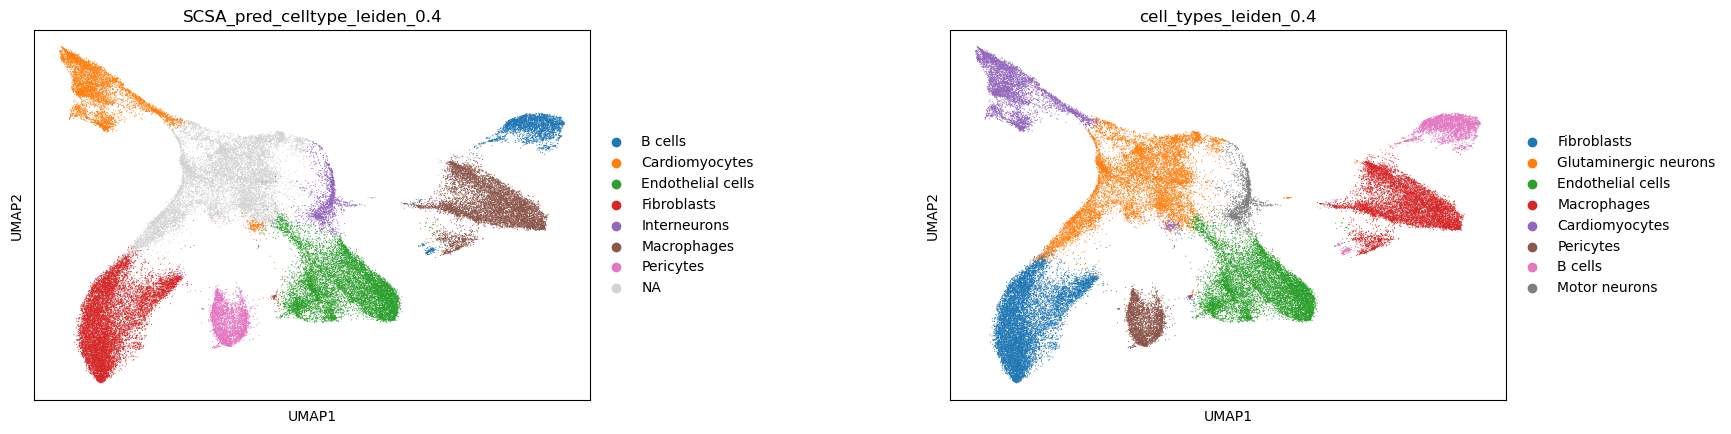

In [31]:
for column in RESOLUTIONS:
    run_scsa(genes_adata,
             gene_column=None,
             gene_symbol='auto',
             key=f'rank_genes_groups_SCSA_{column}',
             column_added=f'SCSA_pred_celltype_{column}',
             inplace=True,
             python_path=None,
             scsa_path=None,
             wholedb_path=None,
             species=None,
             fc=1.5,
             pvalue=0.01,
             tissue='All',
             celltype='normal',
             user_db=SCSA_CUSTOM_DB_PATH,
             z_score='best',
             )
    adata.obs[f'SCSA_pred_celltype_{column}'] = genes_adata.obs[f'SCSA_pred_celltype_{column}']
    sc.pl.umap(adata, color=[f'SCSA_pred_celltype_{column}', f'cell_types_{column}'], wspace=0.5)


## Save notebook and adata object

In [32]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '5_annotation.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.annotation_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)

'/mnt/workspace/jdetlef/ext_ana/processed/all/annotation/5_annotation.ipynb'

In [33]:
adata_output = tree.annotation_anndata
adata.write(filename=adata_output)